In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

import geopandas as gpd
from geobr import read_municipality, read_state
from shapely.geometry import Point

# EAC4 Pollutants (2010-2024)

In [ ]:
"""
Processamento de gases traço (CAMS – ECMFW Atmospheric Composition Reanalysis 4, EAC4)

Etapas do processamento:
1. Leitura do NetCDF contendo concentrações de gases traço do CAMS.
2. Conversão das longitudes do intervalo [0, 360] para [-180, 180],
   garantindo consistência geográfica com ERA5 e outros produtos.
3. Reordenação das longitudes para manter continuidade espacial.
4. Conversão das concentrações de razão de mistura (kg/kg) para
   concentração em massa (µg m⁻³), assumindo densidade do ar constante.
5. Conversão do Dataset final para DataFrame para análise estatística.

Fonte dos dados:
- Copernicus Atmosphere Monitoring Service (CAMS)
- ECMFW Atmospheric Composition Reanalysis 4 (EAC4)
"""

ds = xr.open_dataset(r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\EAC4\pollutants_gases_2010.nc")

# Converter longitudes de 0–360 para -180–180
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
# Ordenar as longitudes para manter ordem geográfica correta
ds = ds.sortby(ds.longitude)

# rho_air = 1.225  # kg/m³
# ds_ugm3 = ds * rho_air * 1e9
# for v in ds_ugm3.data_vars:
#     ds_ugm3[v].attrs["units"] = "µg m-3"

df_aqi = ds.to_dataframe().reset_index()
ds.close()
df_aqi

,valid_time,model_level,latitude,longitude,go3,no2,so2,co
0,2010-01-01 00:00:00,60.0,-14.5,-58.00,1.384579e-08,3.828197e-10,5.183508e-11,1.363492e-07
1,2010-01-01 00:00:00,60.0,-14.5,-57.25,1.113198e-08,7.311767e-10,7.479272e-11,1.408697e-07
2,2010-01-01 00:00:00,60.0,-14.5,-56.50,1.114612e-08,7.560581e-10,6.702960e-11,1.422255e-07
3,2010-01-01 00:00:00,60.0,-14.5,-55.75,1.130205e-08,5.499030e-10,3.915101e-11,1.421041e-07
4,2010-01-01 00:00:00,60.0,-14.5,-55.00,9.737395e-09,9.519157e-10,2.572219e-11,1.420641e-07
...,...,...,...,...,...,...,...,...
2049835,2010-12-31 21:00:00,60.0,-34.0,-42.25,2.526150e-08,1.504242e-11,4.501665e-11,5.296522e-08
2049836,2010-12-31 21:00:00,60.0,-34.0,-41.50,2.539018e-08,1.540191e-11,5.687516e-11,5.300761e-08
2049837,2010-12-31 21:00:00,60.0,-34.0,-40.75,2.548988e-08,1.589308e-11,6.139022e-11,5.322343e-08
2049838,2010-12-31 21:00:00,60.0,-34.0,-40.00,2.554818e-08,1.519874e-11,7.001177e-11,5.338093e-08


In [17]:
def load_cams_gases(path_nc):
    ds = xr.open_dataset(path_nc)

    # converter longitudes 0–360 -> -180–180
    ds = ds.assign_coords(
        longitude=(((ds.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    # opcional: conversão kg/kg -> µg m-3
    # rho_air = 1.225  # kg m-3
    # ds = ds * rho_air * 1e9
    # for v in ds.data_vars:
    #     ds[v].attrs["units"] = "µg m-3"

    df = ds.to_dataframe().reset_index()
    ds.close()
    return df

def load_cams_pm(path_nc):
    ds = xr.open_dataset(path_nc)

    ds = ds.assign_coords(
        longitude=(((ds.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    df = ds.to_dataframe().reset_index()
    ds.close()
    return df

base_cams = Path(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\EAC4"
)

dfs_aqi = []

for year in range(2010, 2025):
    print(f"Lendo CAMS {year}...")

    gases = load_cams_gases(base_cams / f"pollutants_gases_{year}.nc")
    pm    = load_cams_pm(base_cams / f"pollutants_pm_{year}.nc")

    # merge gases + PM
    aqi_year = gases.merge(
        pm,
        on=["valid_time", "latitude", "longitude"],
        how="outer"
    )

    dfs_aqi.append(aqi_year)

df_aqi = pd.concat(dfs_aqi, ignore_index=True)

Lendo CAMS 2010...
Lendo CAMS 2011...
Lendo CAMS 2012...
Lendo CAMS 2013...
Lendo CAMS 2014...
Lendo CAMS 2015...
Lendo CAMS 2016...
Lendo CAMS 2017...
Lendo CAMS 2018...
Lendo CAMS 2019...
Lendo CAMS 2020...
Lendo CAMS 2021...
Lendo CAMS 2022...
Lendo CAMS 2023...
Lendo CAMS 2024...


# ERA5 Meteorology (2010-2024)

In [19]:
"""
Variáveis meteorológicas utilizadas (ERA5 – single levels)

Dimensões:
- valid_time : tempo UTC (3-horário)
- latitude   : graus decimais (positivo norte)
- longitude  : graus decimais (positivo leste)

Variáveis originais ERA5:
- u10   : componente zonal do vento a 10 m [m s-1]
          (positivo de oeste para leste)
- v10   : componente meridional do vento a 10 m [m s-1]
          (positivo de sul para norte)

- t2m   : temperatura do ar a 2 m [K]
- d2m   : temperatura do ponto de orvalho a 2 m [K]

- ssrd  : radiação solar descendente na superfície acumulada
          desde 00 UTC [J m-2]

- blh   : altura da camada limite atmosférica [m]

Variáveis derivadas:
- wind_speed : velocidade do vento a 10 m
               sqrt(u10² + v10²) [m s-1]

- ssrd_flux  : fluxo médio de radiação solar descendente
               calculado por diferença temporal da ssrd
               (intervalo de 3 h = 10800 s) [W m-2]

- RH         : umidade relativa a 2 m [%]
               calculada a partir de t2m e d2m
               segundo formulação padrão WMO

Variáveis técnicas removidas:
- number : índice do membro do ensemble (fixo = 0 no ERA5)
- expver : versão interna do experimento ECMWF
"""

# ------------------------------
# Abrir dataset
# ------------------------------
ds = xr.open_dataset(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\ERA5\meteo_era5_201001.nc"
)

# ------------------------------
# Radiação solar (J/m² -> W/m²)
# ------------------------------
# duração do intervalo (3 horas)
DT = 3 * 3600  # segundos

# diferença temporal
dssrd = ds["ssrd"].diff("valid_time")

# corrigir resets:
# quando a diferença é negativa, usar o valor acumulado atual
dssrd_corrected = xr.where(
    dssrd >= 0,
    dssrd,
    ds["ssrd"].isel(valid_time=slice(1, None))
)

# converter para fluxo médio
ds["ssrd_flux"] = dssrd_corrected / DT

# atributos (boa prática)
ds["ssrd_flux"].attrs["units"] = "W m-2"
ds["ssrd_flux"].attrs["long_name"] = "Surface solar radiation downward (mean flux over 3h)"

# ------------------------------
# Velocidade do vento
# ------------------------------
ds["wind_speed"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
ds["wind_speed"].attrs["units"] = "m s-1"
ds["wind_speed"].attrs["long_name"] = "10 m wind speed"

# ------------------------------
# Umidade relativa (%)
# ------------------------------
RH = mpcalc.relative_humidity_from_dewpoint(
    ds["t2m"] * units.kelvin,
    ds["d2m"] * units.kelvin
)

ds["RH"] = RH.metpy.dequantify() * 100
ds["RH"].attrs["units"] = "%"
ds["RH"].attrs["long_name"] = "Relative humidity at 2 m"

# ------------------------------
# Limpeza
# ------------------------------
ds = ds.drop_vars(["number", "expver"])

# ------------------------------
# Converter para DataFrame
# ------------------------------
df_meteo = ds.to_dataframe().reset_index()

ds.close()
df_meteo

,valid_time,latitude,longitude,ssrd,u10,v10,t2m,d2m,blh,ssrd_flux,wind_speed,RH
0,2010-01-01 00:00:00,-14.5,-58.00,0.0,2.332703,-1.822403,297.931152,294.382812,618.560547,NaN,2.960178,80.697075
1,2010-01-01 00:00:00,-14.5,-57.25,0.0,1.009460,-1.395645,298.688965,295.449219,295.498047,NaN,1.722450,82.329346
2,2010-01-01 00:00:00,-14.5,-56.50,0.0,1.276062,-0.833145,297.546387,295.589844,318.998047,NaN,1.523964,88.880394
3,2010-01-01 00:00:00,-14.5,-55.75,0.0,-0.223938,-1.069473,297.569824,295.843750,49.935532,NaN,1.092667,90.132980
4,2010-01-01 00:00:00,-14.5,-55.00,0.0,-0.118469,-0.898575,296.722168,295.466797,46.685532,NaN,0.906351,92.689796
...,...,...,...,...,...,...,...,...,...,...,...,...
174091,2010-01-31 21:00:00,-34.0,-42.25,690816.0,0.399445,-4.272995,296.268799,295.137207,332.934845,63.964443,4.291625,93.366760
174092,2010-01-31 21:00:00,-34.0,-41.50,734848.0,-0.077118,-4.863815,296.198486,295.223145,293.809845,68.041481,4.864427,94.256065
174093,2010-01-31 21:00:00,-34.0,-40.75,725568.0,-0.292938,-4.859909,295.639893,294.785645,267.559845,67.182220,4.868730,94.932098
174094,2010-01-31 21:00:00,-34.0,-40.00,697216.0,-0.027313,-4.841354,295.569580,294.814941,313.309845,64.557037,4.841432,95.508804


In [20]:
base_path = Path(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\ERA5"
)

dfs_meteo = []
DT = 3 * 3600  # 3 horas em segundos

for year in range(2010, 2025):
    for month in range(1, 13):
        file = base_path / f"meteo_era5_{year}{month:02d}.nc"
        if not file.exists():
            continue

        print(f"Lendo ERA5 {year}{month:02d}")

        ds = xr.open_dataset(file)

        # ----------------------
        # SSRD -> fluxo médio
        # ----------------------
        dssrd = ds["ssrd"].diff("valid_time")

        dssrd_corrected = xr.where(
            dssrd >= 0,
            dssrd,
            ds["ssrd"].isel(valid_time=slice(1, None))
        )

        ds["ssrd_flux"] = dssrd_corrected / DT
        ds["ssrd_flux"].attrs["units"] = "W m-2"

        # ----------------------
        # Velocidade do vento
        # ----------------------
        ds["wind_speed"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
        ds["wind_speed"].attrs["units"] = "m s-1"

        # ----------------------
        # Umidade relativa
        # ----------------------
        RH = mpcalc.relative_humidity_from_dewpoint(
            ds["t2m"] * units.kelvin,
            ds["d2m"] * units.kelvin
        )
        ds["RH"] = RH.metpy.dequantify() * 100
        ds["RH"].attrs["units"] = "%"

        # ----------------------
        # Limpeza
        # ----------------------
        ds = ds.drop_vars(["number", "expver"])

        df = ds.to_dataframe().reset_index()
        dfs_meteo.append(df)

        ds.close()

df_meteo = pd.concat(dfs_meteo, ignore_index=True)
print("ERA5 finalizado:", df_meteo.shape)

Lendo ERA5 201001
Lendo ERA5 201002
Lendo ERA5 201003
Lendo ERA5 201004
Lendo ERA5 201005
Lendo ERA5 201006
Lendo ERA5 201007
Lendo ERA5 201008
Lendo ERA5 201009
Lendo ERA5 201010
Lendo ERA5 201011
Lendo ERA5 201012
Lendo ERA5 201101
Lendo ERA5 201102
Lendo ERA5 201103
Lendo ERA5 201104
Lendo ERA5 201105
Lendo ERA5 201106
Lendo ERA5 201107
Lendo ERA5 201108
Lendo ERA5 201109
Lendo ERA5 201110
Lendo ERA5 201111
Lendo ERA5 201112
Lendo ERA5 201201
Lendo ERA5 201202
Lendo ERA5 201203
Lendo ERA5 201204
Lendo ERA5 201205
Lendo ERA5 201206
Lendo ERA5 201207
Lendo ERA5 201208
Lendo ERA5 201209
Lendo ERA5 201210
Lendo ERA5 201211
Lendo ERA5 201212
Lendo ERA5 201301
Lendo ERA5 201302
Lendo ERA5 201303
Lendo ERA5 201304
Lendo ERA5 201305
Lendo ERA5 201306
Lendo ERA5 201307
Lendo ERA5 201308
Lendo ERA5 201309
Lendo ERA5 201310
Lendo ERA5 201311
Lendo ERA5 201312
Lendo ERA5 201401
Lendo ERA5 201402
Lendo ERA5 201403
Lendo ERA5 201404
Lendo ERA5 201405
Lendo ERA5 201406
Lendo ERA5 201407
Lendo ERA5

# Merge

In [21]:
# garantir tipos consistentes
for col in ["latitude", "longitude"]:
    df_aqi[col] = df_aqi[col].astype("float32")
    df_meteo[col] = df_meteo[col].astype("float32")

df_aqi["valid_time"] = pd.to_datetime(df_aqi["valid_time"])
df_meteo["valid_time"] = pd.to_datetime(df_meteo["valid_time"])

merged = df_aqi.merge(
    df_meteo,
    how="left",
    on=["valid_time", "latitude", "longitude"],
)

print("Dataset final:", merged.shape)

Dataset final: (30770064, 19)


In [23]:
merged.to_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024.parquet",
    index=False,
)

# Brazilian Land Only

In [3]:
df = pd.read_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024.parquet",
)

In [13]:
# Estados de interesse
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]

# Shapefile dos estados
br_states = read_state(year=2020).to_crs("EPSG:4326")

# Filtrar apenas os estados desejados
br_reg = br_states[br_states["abbrev_state"].isin(ufs_interesse)]

# GeoDataFrame dos pontos
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# Recorte espacial
gdf_reg = gpd.sjoin(
    gdf,
    br_reg,
    predicate="within",
    how="inner"
)

# Voltar para pandas
df_reg = (
    gdf_reg
    .drop(columns=["geometry", "index_right"], errors="ignore")
    .reset_index(drop=True)
)

print("Antes:", len(df))
print("Depois:", len(df_reg))

Antes: 17006816
Depois: 12623616


In [15]:
# Remover colunas do shapefile e a geometria
df_br = (
    df_reg
    .drop(columns=["geometry", "index_right"], errors="ignore")
    .reset_index(drop=True)
)

print(type(df_br))
df_br

<class 'pandas.core.frame.DataFrame'>


,valid_time,model_level,latitude,longitude,go3,no2,so2,co,pm2p5,pm10,...,code_state_left,abbrev_state_left,name_state_left,code_region_left,name_region_left,code_state_right,abbrev_state_right,name_state_right,code_region_right,name_region_right
0,2010-01-01 00:00:00,60.0,-33.25,-52.75,2.861315e-08,2.743359e-10,3.324004e-10,5.231169e-08,4.895200e-09,8.643736e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
1,2010-01-01 00:00:00,60.0,-31.75,-54.25,2.634722e-08,1.073285e-09,6.707889e-10,5.073998e-08,3.978073e-09,6.335453e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
2,2010-01-01 00:00:00,60.0,-31.75,-53.50,2.600291e-08,8.254755e-10,2.941040e-10,4.845091e-08,4.254268e-09,6.869248e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
3,2010-01-01 00:00:00,60.0,-31.75,-52.75,2.692569e-08,8.175485e-10,4.164261e-10,4.688323e-08,4.730013e-09,7.806067e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
4,2010-01-01 00:00:00,60.0,-31.00,-55.00,2.853845e-08,1.232108e-09,5.866806e-10,5.313185e-08,3.533827e-09,5.482987e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623611,2024-12-31 21:00:00,60.0,-15.25,-44.50,3.191286e-08,2.099574e-10,6.161720e-11,1.055335e-07,6.808490e-09,9.624326e-09,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623612,2024-12-31 21:00:00,60.0,-15.25,-43.75,3.029765e-08,2.719892e-10,8.006644e-11,1.059256e-07,7.026069e-09,9.819862e-09,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623613,2024-12-31 21:00:00,60.0,-15.25,-43.00,3.150103e-08,4.253585e-10,1.192791e-10,1.096794e-07,7.925463e-09,1.083076e-08,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623614,2024-12-31 21:00:00,60.0,-15.25,-42.25,3.192256e-08,4.638837e-10,1.200438e-10,1.113640e-07,9.784328e-09,1.309615e-08,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste


In [16]:
df_br.to_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil.parquet",
    index=False,
)

# Simple EDA

In [10]:
df = pd.read_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil.parquet",
)

### Check Geography

In [18]:
print("Linhas:", len(df), "→", len(df))

print("Lat min/max:", df["latitude"].min(), df["latitude"].max())
print("Lon min/max:", df["longitude"].min(), df["longitude"].max())


Linhas: 17006816 → 17006816
Lat min/max: -33.25 -14.5
Lon min/max: -58.0 -39.25


### Check NetCDF Units

In [ ]:
ds_g = xr.open_dataset("raw\EAC4\pollutants_gases_2010.nc")
print({v: ds_g[v].attrs.get("units") for v in ds_g.data_vars})

ds_pm = xr.open_dataset("raw\EAC4\pollutants_pm_2010.nc")
print({v: ds_pm[v].attrs.get("units") for v in ds_pm.data_vars})

{'go3': 'kg kg**-1', 'no2': 'kg kg**-1', 'so2': 'kg kg**-1', 'co': 'kg kg**-1'}
{'pm2p5': 'kg m**-3', 'pm10': 'kg m**-3'}


<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_33676\3608288355.py:1: SyntaxWarning: invalid escape sequence '\E'
  ds_g = xr.open_dataset("raw\EAC4\pollutants_gases_2010.nc")
C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_33676\3608288355.py:4: SyntaxWarning: invalid escape sequence '\E'
  ds_pm = xr.open_dataset("raw\EAC4\pollutants_pm_2010.nc")


### Check Time Frequency

In [37]:
t = pd.to_datetime(df["valid_time"])
counts = pd.Series(1, index=t).resample("D").sum()

print(counts.describe())
print("Min/Max por dia:", counts.min(), counts.max())

# 5479 dias ≈ 15 anos → consistente com 2010–2024
# 5616 linhas por dia → estrutura espaço-tempo perfeita
# zero variabilidade → pipeline sólido

count    5479.0
mean     5616.0
std         0.0
min      5616.0
25%      5616.0
50%      5616.0
75%      5616.0
max      5616.0
dtype: float64
Min/Max por dia: 5616 5616


### Check Model Level

In [38]:
df["model_level"].unique()

array([60.])

### Check Grid and Order

In [ ]:
key = ["valid_time","latitude","longitude"]
dups = df.duplicated(key).sum()
print("Duplicatas:", dups)

print(df[["latitude","longitude"]].describe())
print("N lats:", df["latitude"].nunique(), "N lons:", df["longitude"].nunique())

# Nenhum (tempo, lat, lon) repetido → merge limpo, sem sobreposição indevida.
# 27 × 26 = 702 células, exatamente o correto.
# ➡️ RQ2 (generalização espacial) está totalmente viável com esse dataset.

Duplicatas: 0
           latitude     longitude
count  3.077006e+07  3.077006e+07
mean  -2.425000e+01 -4.862500e+01
std    5.841660e+00  5.625000e+00
min   -3.400000e+01 -5.800000e+01
25%   -2.950000e+01 -5.350000e+01
50%   -2.425000e+01 -4.862500e+01
75%   -1.900000e+01 -4.375000e+01
max   -1.450000e+01 -3.925000e+01
N lats: 27 N lons: 26


### Scale Sanity Check

2️⃣ Escala física dos poluentes (o ponto mais sensível)

Vou comentar variável por variável, porque aqui mora a diferença entre “parece certo” e “está certo”.

🟢 PM2.5 e PM10 — IMPECÁVEL
pm2p5 max 6.25e-06 kg/m³  → 6.25 µg/m³
pm10  max 8.24e-06 kg/m³  → 8.24 µg/m³
out_hi = 0


✔️ Faixa totalmente realista
✔️ Nenhum outlier absurdo
✔️ Conversão direta para µg/m³ trivial (*1e9)

👉 Essas séries estão prontas para modelagem.

🟡 O₃ (go3)
max 6.02e-07 kg/kg
out_hi = 7


Converter mentalmente:

6e-07 kg/kg ≈ ~350–400 ppb (evento extremo, mas fisicamente possível em reanálise)

✔️ Pouquíssimos outliers
✔️ Compatível com eventos fotoquímicos intensos

➡️ Nada de errado aqui.

🟡 NO₂
max 7.93e-07 kg/kg
out_hi = 4997


Isso assusta à primeira vista, mas aqui está o detalhe importante:

👉 Seu limite hi = 5e-8 é conservador demais para NO₂.

CAMS não é estação urbana, é modelo assimilado

Em células urbanas/industriais, NO₂ pode subir bastante

Esses “out_hi” não são erros numéricos, são cauda pesada real do modelo

✔️ Ordem de grandeza ainda é fisicamente plausível
✔️ Não há explosão (ex.: 1e-3 kg/kg, o que seria absurdo)

📌 Conclusão:
Não é problema de dado — é distribuição assimétrica, o que inclusive fortalece sua RQ4 (extremos).

🟡 SO₂
max 2.88e-07 kg/kg
out_hi = 734


Mesmo raciocínio do NO₂:

SO₂ é altamente localizado

Regiões industriais / termoelétricas geram picos

✔️ Valores coerentes com reanálise global
✔️ Outliers são poucos em termos relativos

🟡 CO
max 1.02e-04 kg/kg
out_hi = 2222


CO sempre tem escala maior mesmo.

Valores típicos: 1e-08 → 1e-05

Picos em queima/biomassa e tráfego intenso

✔️ Totalmente compatível com CAMS
✔️ Nenhum indício de erro de unidade

3️⃣ O ponto-chave: seus “out_hi” não indicam erro

Eles indicam exatamente:

distribuição não-Gaussiana

cauda longa

eventos raros mal capturados por métricas médias

👉 Isso é ouro para a dissertação, porque conecta diretamente com:

RQ4 (eventos extremos)

discussão de por que MAE/RMSE são “bons”, mas MAX é ruim

necessidade de métricas condicionais / pinball / recall de eventos

Você não quer “consertar” isso — você quer analisar isso.

In [ ]:
checks = {
  "go3": (0, 5e-7),   # kg/kg (bem folgado)
  "no2": (0, 5e-8),
  "so2": (0, 5e-8),
  "co":  (0, 5e-6),
  "pm2p5": (0, 5e-4), # kg/m3 (5e-4 = 500 µg/m³)
  "pm10":  (0, 5e-4),
}

for col,(lo,hi) in checks.items():
    x = df[col].to_numpy()
    print(col, "min", np.nanmin(x), "max", np.nanmax(x), "out_hi", np.sum(x>hi))

# ✔️ Faixa totalmente realista
# ✔️ Nenhum outlier absurdo
# ✔️ Conversão direta para µg/m³ trivial (*1e9)
# 👉 Essas séries estão prontas para modelagem.

go3 min 9.999998e-15 max 6.024491e-07 out_hi 7
no2 min 9.999998e-15 max 7.9252794e-07 out_hi 4997
so2 min 9.9999946e-26 max 2.8816945e-07 out_hi 734
co min 9.999999e-15 max 0.00010212802 out_hi 2222
pm2p5 min 0.0 max 6.249715e-06 out_hi 0
pm10 min 0.0 max 8.236874e-06 out_hi 0


## Brief Visualization

<Axes: xlabel='valid_time'>

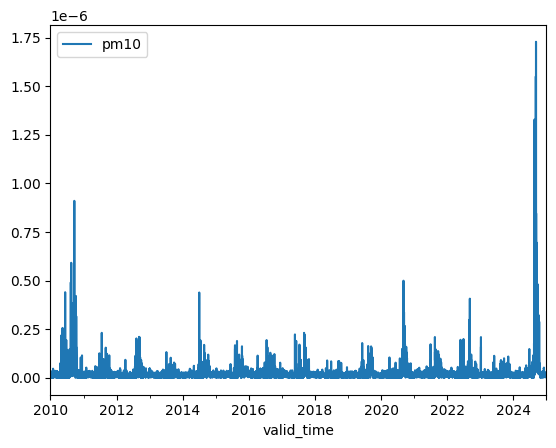

In [11]:
df.query("latitude == -14.5 and longitude == -58.0").groupby('valid_time')[['pm10']].mean().plot()

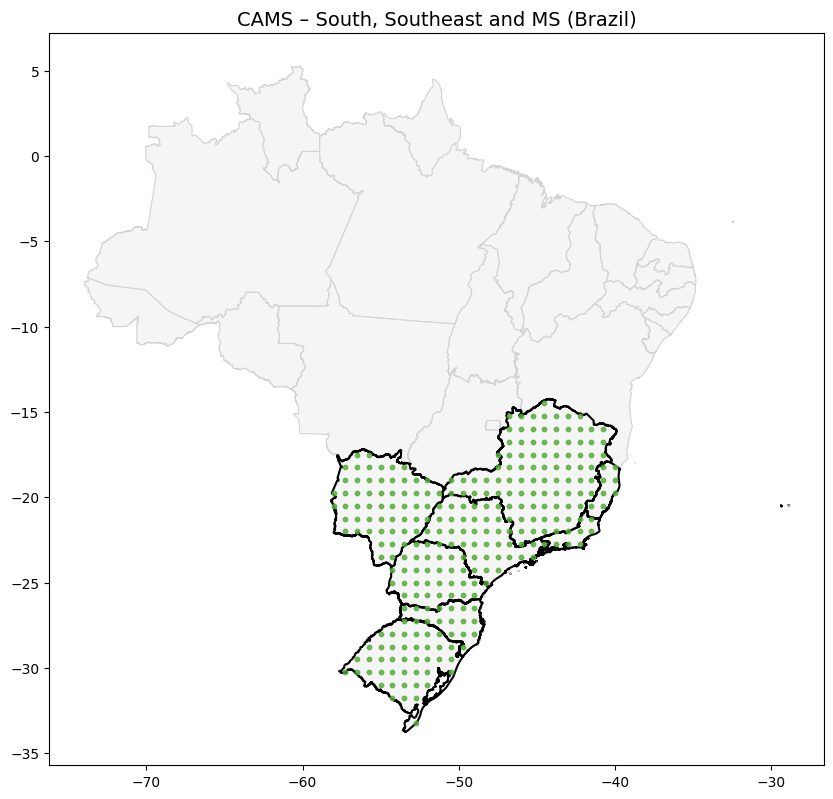

In [22]:
# Shapefile do Brasil inteiro (estados)
br_all = read_state(year=2020).to_crs("EPSG:4326")

# Estados de interesse (já definido antes)
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]
br_reg = br_all[br_all["abbrev_state"].isin(ufs_interesse)]

# Grade espacial única
gdf_grid = (
    gdf_reg[["latitude", "longitude", "geometry"]]
    .drop_duplicates()
)

fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Brasil inteiro (fundo)
br_all.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="lightgray",
    linewidth=0.8
)

# 2️⃣ Região de estudo destacada
br_reg.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5
)

# 3️⃣ Grade CAMS
gdf_grid.plot(
    ax=ax,
    markersize=10,
    color="#54ac35",
    alpha=0.8
)

ax.set_title("CAMS – South, Southeast and MS (Brazil)", fontsize=14)
plt.show()

In [ ]:
# # buffer negativo (ex.: remover 0.1° da costa)
# br_buffered = br.buffer(-0.1)

# gdf_br = gpd.sjoin(
#     gdf,
#     br_buffered,
#     predicate="within",
#     how="inner"
# )

In [ ]:
# # 1️⃣ Carrega o shapefile do Paraná (municípios)
# pr = read_municipality(code_muni="PR", year=2020)

# # 3️⃣ Cria GeoDataFrame dos pontos
# gdf = gpd.GeoDataFrame(
#     df,
#     geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
#     crs="EPSG:4326"
# )

# # 4️⃣ Converte para projeção em metros (para poder medir o raio corretamente)
# gdf_m = gdf.to_crs("EPSG:31982")  # SIRGAS 2000 / UTM zone 22S, cobre o Paraná

# # 5️⃣ Cria buffers (raio) de 20 km em torno de cada ponto
# #    (ajuste aqui para 10_000 ou 40_000 para mudar o raio)
# buffers = gdf_m.copy()
# buffers["geometry"] = buffers.buffer(27_000)  # 20 km de raio

# # 6️⃣ Reprojeta de volta pra WGS84 (pra plotar junto com o shapefile)
# buffers = buffers.to_crs("EPSG:4326")

# # 7️⃣ Plota
# fig, ax = plt.subplots(figsize=(10, 10))
# pr.plot(ax=ax, color="whitesmoke", edgecolor="gray")
# buffers.plot(ax=ax, color="none", alpha=0.1, edgecolor="darkred")  # áreas de influência
# gdf.plot(ax=ax, markersize=5, color="darkred")  # pontos centrais

# ax.set_title("Área de influência (~27 km) dos pontos CAMS sobre o Paraná", fontsize=14)
# plt.show()
